# Using a Creator to Calculate True Posteriors for a Galaxy Sample

This notebook demonstrates how to use a RAIL Creator to calculate true posteriors for galaxy samples drawn from the same Creator. Note that this notebook assumes you have already read through `degradation-demo.ipynb`.

Calculating posteriors is more complicated than drawing samples, because it requires more knowledge of the engine that underlies the Creator. In this example, we will use the same engine we used in Degradation demo: `FlowEngine` which wraps a normalizing flow from the [pzflow](https://github.com/jfcrenshaw/pzflow) package.

This notebook will cover three scenarios of increasing complexity:
1. [**Calculating posteriors without errors**](#NoErrors)
2. [**Calculating posteriors while convolving errors**](#ErrConv)
3. [**Calculating posteriors with missing bands**](#MissingBands)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pzflow.examples import get_example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import (
    InvRedshiftIncompleteness,
    LineConfusion,
    LSSTErrorModel,
    QuantityCut,
)


Found classifier FZBoost
Found classifier randomPZ
Found classifier simpleNN
Found classifier trainZ
Found classifier BPZ_lite


<a id="NoErrors"></a>
## 1. Calculating posteriors without errors

For a basic first example, let's make a Creator with no degradation and draw a sample.

In [2]:
# create the FlowEngine
flowEngine = engines.FlowEngine(get_example_flow())
# create the Creator for the true distribution
creator_truth = Creator(flowEngine)
# draw a few samples
samples_truth = creator_truth.sample(6, seed=0)

Now, let's calculate true posteriors for this sample. Note the important fact here: these are literally the true posteriors for the sample because pzflow gives us direct access to the probability distribution from which the sample was drawn!

When calculating posteriors, the Creator will always require `data`, which is a pandas DataFrame of the galaxies for which we are calculating posteriors. Because we are using a Creator built on `FlowEngine`, we also must provide `grid`, because `FlowEngine` calculates posteriors over a grid of redshift values.

Let's calculate posteriors for every galaxy in our sample:

In [3]:
grid = np.linspace(0, 2.5, 100)
pdfs = creator_truth.get_posterior(samples_truth, grid=grid)

Note that Creator returns the pdfs as a [qp](https://github.com/LSSTDESC/qp) Ensemble:

In [4]:
pdfs

Let's plot these pdfs: 

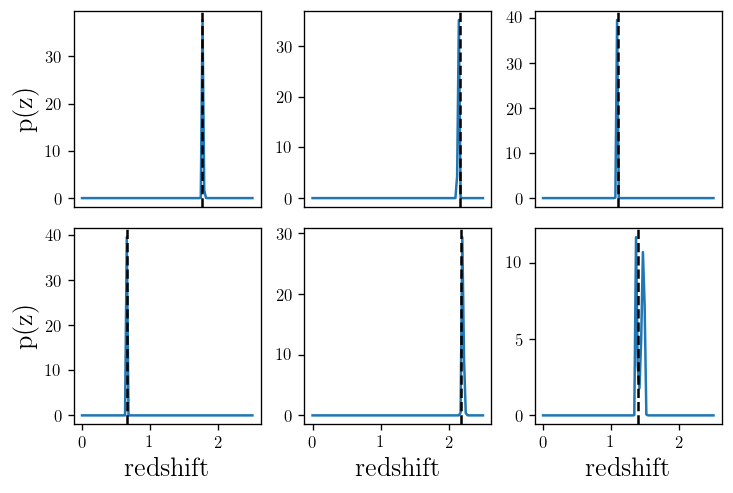

In [5]:
fig, axes = plt.subplots(2, 3, constrained_layout=True, dpi=120)

for i, ax in enumerate(axes.flatten()):

    # plot the pdf
    pdfs[i].plot_native(axes=ax)

    # plot the true redshift
    ax.axvline(samples_truth["redshift"][i], c="k", ls="--")

    # remove x-ticks on top row
    if i < 3:
        ax.set(xticks=[])
    # set x-label on bottom row
    else:
        ax.set(xlabel="redshift")
    # set y-label on far left column
    if i % 3 == 0:
        ax.set(ylabel="p(z)")

The true posteriors are in blue, and the true redshifts are marked by the vertical black lines.

<a id="ErrConv"></a>
## 2. Calculating posteriors while convolving errors
Now, let's get a little more sophisticated.

Let's recreate the Creator we were using at the end of the Degradation demo. 

I will make one change however:
the LSST Error Model sometimes results in non-detections for faint galaxies.
These non-detections are flagged with NaN.
Calculating posteriors for galaxies with missing magnitudes is more complicated, so for now, I will add one additional QuantityCut to remove any galaxies with missing magnitudes.
To see how to calculate posteriors for galaxies with missing magnitudes, see [Section 3](#MissingBands).

In [6]:
# set up the error model
errorModel = LSSTErrorModel(bandNames={f"lsst_{b}": b for b in "ugrizy"})

def degrader_cut_nondetects(data: pd.DataFrame, seed: int = None) -> pd.DataFrame:
    # apply the error model
    data = errorModel(data, seed)

    # make a cut on the observed i band
    data = QuantityCut({"i": 25.3})(data, seed)

    # introduce redshift incompleteness
    data = InvRedshiftIncompleteness(0.8)(data, seed)

    # introduce spectroscopic errors
    # Oxygen lines (in angstroms)
    OII = 3727
    OIII = 5007
    # 2% OII -> OIII confusion
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)(data, seed)
    # 1% OIII -> OII confusion
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)(data, seed)

    # remove all galaxies with non-detections
    # note that since non-detections are flagged with np.nan, it is enough
    # to specify infinity as the maximum magnitude, since np.nan < np.inf
    # evaluates to false
    data = QuantityCut({band: np.inf for band in "ugrizy"})(data, seed)

    return data

In [7]:
creator_degraded_wo_nondetects = Creator(flowEngine, degrader=degrader_cut_nondetects)

Now let's draw a degraded sample:

In [8]:
samples_degraded_wo_nondetects = creator_degraded_wo_nondetects.sample(6, seed=1)
samples_degraded_wo_nondetects

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,1.064106,27.365097,0.677571,26.487594,0.095356,25.753190,0.047949,25.231183,0.044668,24.549497,0.043006,24.307474,0.080426
1,0.482760,26.614933,0.339908,25.918338,0.056706,25.014163,0.024745,24.683647,0.027342,24.470171,0.040033,24.363027,0.084622
2,0.780575,27.124128,0.542854,26.218161,0.074528,25.616368,0.042359,24.836579,0.031320,24.625664,0.046076,24.366805,0.084915
3,0.892465,25.999356,0.193150,25.823601,0.052029,25.050566,0.025549,24.288076,0.019385,23.761823,0.021374,23.643656,0.043931
4,0.578258,24.182519,0.037115,23.451824,0.007866,22.653740,0.005788,22.135732,0.005699,21.958094,0.006468,21.826354,0.009728
5,1.888028,27.129330,0.545457,26.140760,0.069443,25.565113,0.040443,25.039558,0.037570,24.421706,0.038321,24.230015,0.074924


This sample has photometric errors that we would like to convolve in the redshift posteriors, so that the posteriors are fully consistent with the errors. We can perform this convolution by sampling from the error distributions, calculating posteriors, and averaging.

`FlowEngine` has this functionality already built in - we just have to provide `err_samples` to the `get_posterior` method.

Let's calculate posteriors with a variable number of error samples.

In [9]:

pdfs_errs_convolved = {
    err_samples:
    creator_degraded_wo_nondetects.get_posterior(
        samples_degraded_wo_nondetects, 
        grid=grid, 
        err_samples=err_samples,
        seed=0,
        batch_size=2,
    )
    for err_samples in [1, 10, 100, 1000]
}

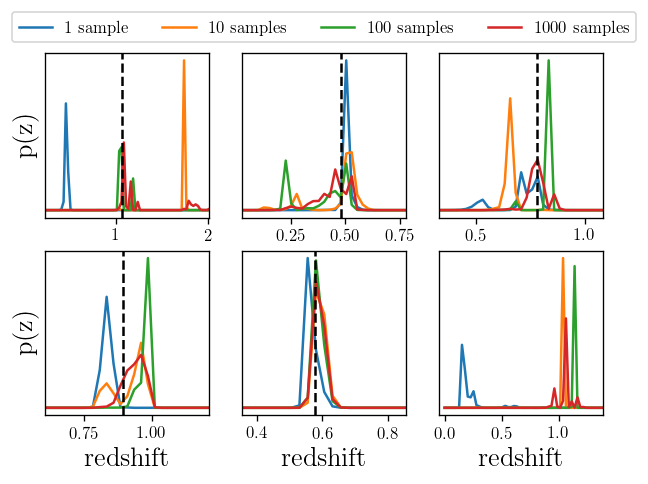

In [10]:
fig, axes = plt.subplots(2, 3, dpi=120)

for i, ax in enumerate(axes.flatten()):

    # set dummy values for xlim
    xlim = [np.inf, -np.inf]

    for pdfs_ in pdfs_errs_convolved.values():

        # plot the pdf
        pdfs_[i].plot_native(axes=ax)

        # get the x value where the pdf first rises above 2
        xmin = grid[np.argmax(pdfs_[i].pdf(grid)[0] > 2)]
        if xmin < xlim[0]:
            xlim[0] = xmin
            
        # get the x value where the pdf finally falls below 2   
        xmax = grid[-np.argmax(pdfs_[i].pdf(grid)[0, ::-1] > 2)]
        if xmax > xlim[1]:
            xlim[1] = xmax

    # plot the true redshift
    z_true = samples_degraded_wo_nondetects["redshift"][i]
    ax.axvline(z_true, c="k", ls="--")

    # set x-label on bottom row
    if i >= 3:
        ax.set(xlabel="redshift")
    # set y-label on far left column
    if i % 3 == 0:
        ax.set(ylabel="p(z)")

    # set the x-limits so we can see more detail
    xlim[0] -= 0.2
    xlim[1] += 0.2
    ax.set(xlim=xlim, yticks=[])

# create the legend
axes[0, 1].plot([], [], c="C0", label=f"1 sample")
for i, n in enumerate([10, 100, 1000]):
    axes[0, 1].plot([], [], c=f"C{i+1}", label=f"{n} samples")
axes[0, 1].legend(
    bbox_to_anchor=(0.5, 1.3), 
    loc="upper center",
    ncol=4,
)

plt.show()

You can see the effect of convolving the errors. In particular, notice that without error convolution (1 sample), the redshift posterior is often totally inconsistent with the true redshift (marked by the vertical black line). As you convolve more samples, the posterior generally broadens and becomes consistent with the true redshift.

Also notice how the posterior continues to change as you convolve more and more samples. This suggests that you need to do a little testing to ensure that you have convolved enough samples.

Let's plot these same posteriors with even more samples to make sure they have converged:

**WARNING**: Running the next cell on your computer may exhaust your memory

In [11]:
pdfs_errs_convolved_more_samples = {
    err_samples:
    creator_degraded_wo_nondetects.get_posterior(
        samples_degraded_wo_nondetects, 
        grid=grid, 
        err_samples=err_samples,
        seed=0,
        batch_size=2
    )
    for err_samples in [1000, 2000, 5000, 10000]
}

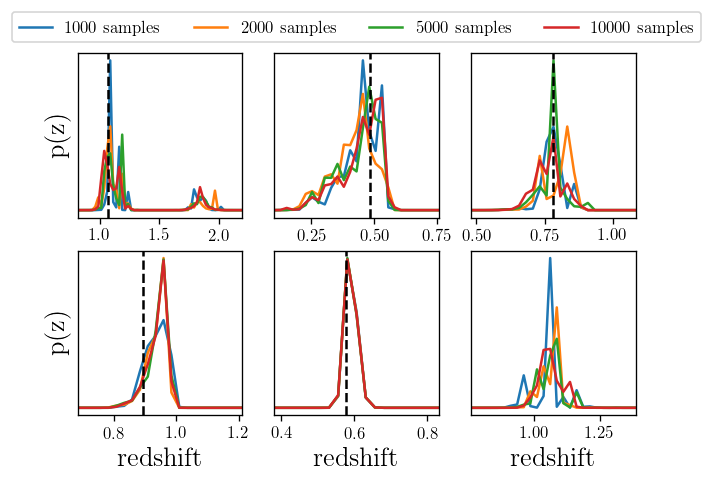

In [12]:
fig, axes = plt.subplots(2, 3, dpi=120)

for i, ax in enumerate(axes.flatten()):

    # set dummy values for xlim
    xlim = [np.inf, -np.inf]

    for pdfs_ in pdfs_errs_convolved_more_samples.values():

        # plot the pdf
        pdfs_[i].plot_native(axes=ax)

        # get the x value where the pdf first rises above 2
        xmin = grid[np.argmax(pdfs_[i].pdf(grid)[0] > 2)]
        if xmin < xlim[0]:
            xlim[0] = xmin
            
        # get the x value where the pdf finally falls below 2
        xmax = grid[-np.argmax(pdfs_[i].pdf(grid)[0, ::-1] > 2)]
        if xmax > xlim[1]:
            xlim[1] = xmax

    # plot the true redshift
    z_true = samples_degraded_wo_nondetects["redshift"][i]
    ax.axvline(z_true, c="k", ls="--")

    # set x-label on bottom row
    if i >= 3:
        ax.set(xlabel="redshift")
    # set y-label on far left column
    if i % 3 == 0:
        ax.set(ylabel="p(z)")

    # set the x-limits so we can see more detail
    xlim[0] -= 0.2
    xlim[1] += 0.2
    ax.set(xlim=xlim, yticks=[])

# create the legend
for i, n in enumerate([1000, 2000, 5000, 10000]):
    axes[0, 1].plot([], [], c=f"C{i}", label=f"{n} samples")
axes[0, 1].legend(
    bbox_to_anchor=(0.5, 1.3), 
    loc="upper center",
    ncol=4,
)

plt.show()

Notice that two of these galaxies may take upwards of 10,000 samples to converge (convolving over 10,000 samples takes 0.5 seconds / galaxy on my computer)

<a id="MissingBands"></a>
## 3. Calculating posteriors with missing bands

Now let's finally tackle posterior calculation with missing bands.

First, lets make a sample that has missing bands. Let's use the same degrader as we used above, except without the final QuantityCut that removed non-detections:

In [13]:
# set up the error model
errorModel = LSSTErrorModel(bandNames={f"lsst_{b}": b for b in "ugrizy"})

def degrader(data: pd.DataFrame, seed: int = None) -> pd.DataFrame:
    # apply the error model
    data = errorModel(data, seed)

    # make a cut on the observed i band
    data = QuantityCut({"i": 25.3})(data, seed)

    # introduce redshift incompleteness
    data = InvRedshiftIncompleteness(0.8)(data, seed)

    # introduce spectroscopic errors
    # Oxygen lines (in angstroms)
    OII = 3727
    OIII = 5007
    # 2% OII -> OIII confusion
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)(data, seed)
    # 1% OIII -> OII confusion
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)(data, seed)

    return data

In [14]:
creator_degraded = Creator(flowEngine, degrader=degrader)

In [15]:
samples_degraded = creator_degraded.sample(6, seed=0)
samples_degraded

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,0.733024,25.721219,0.149687,23.894436,0.010289,22.347650,0.005480,21.081648,0.005128,20.602451,0.005168,20.334165,0.005484
1,0.476285,26.459018,0.294541,26.372428,0.085815,25.537758,0.039456,25.276943,0.046560,25.225383,0.079588,24.914923,0.140394
2,0.260037,25.854305,0.169098,24.792150,0.020810,23.928254,0.010322,23.612614,0.011305,23.327009,0.014855,23.300840,0.032272
3,1.358130,NaN,NaN,27.100063,0.167253,25.723847,0.046689,23.919356,0.014292,23.233337,0.013787,22.345411,0.014246
4,0.579832,27.193428,0.578585,26.695562,0.115377,25.746822,0.047673,25.221602,0.044283,25.247596,0.081223,25.068355,0.161648
5,1.321674,26.777683,0.394754,25.485161,0.038322,24.783012,0.020250,23.914385,0.014236,23.240419,0.013864,22.621623,0.017862


You can see that galaxy 3 has a non-detection in the u band. `FlowEngine` can handle missing values by marginalizing over that value. By default, `FlowEngine` will marginalize over NaNs in the u band, using the grid `u = np.linspace(25, 31, 10)`. This default grid should work in most cases, but you may want to change the flag for non-detections, use a different grid for the u band, or marginalize over non-detections in other bands. In order to do these things, you must supply `FlowEngine` with marginalization rules in the form of the `marg_rules` dictionary.

Let's imagine we want to use a different grid for u band marginalization. In order to determine what grid to use, we will create a histogram of non-detections in u band vs true u band magnitude (assuming year 10 LSST errors). This will tell me what are reasonable values of u to marginalize over.

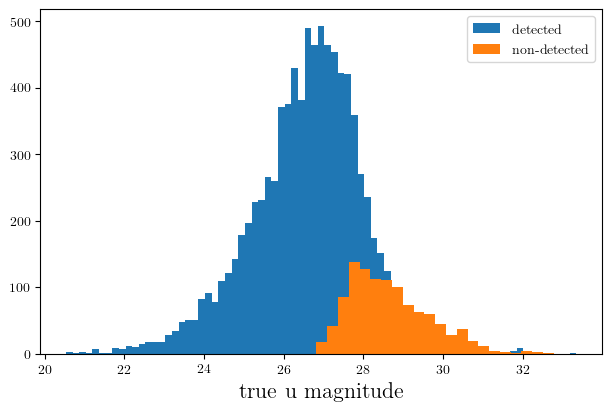

In [16]:
# get true u band magnitudes
true_u = Creator(flowEngine, degrader=None).sample(10000, seed=0)["u"].to_numpy()
# get the observed u band magnitudes
obs_u = Creator(flowEngine, degrader=errorModel).sample(10000, seed=0)["u"].to_numpy()

# create the figure
fig, ax = plt.subplots(constrained_layout=True, dpi=100)
# plot the u band detections
ax.hist(true_u[~np.isnan(obs_u)], bins="fd", label="detected")
# plot the u band non-detections
ax.hist(true_u[np.isnan(obs_u)], bins="fd", label="non-detected")

ax.legend()
ax.set(xlabel="true u magnitude")

plt.show()

Based on this histogram, I will marginalize over u band values from 27 to 31. Like how I tested different numbers of error samples above, here I will test different resolutions for the u band grid.

I will provide our new u band grid in the `marg_rules` dictionary, which will also include `"flag"` which tells `FlowEngine` what my flag for non-detections is.
In this simple example, we are using a fixed grid for the u band, but notice that the u band rule takes the form of a function - this is because the grid over which to marginalize can be a function of any of the other variables in the row. 
If I wanted to marginalize over any other bands, I would need to include corresponding rules in `marg_rules` too.

For this example, I will only calculate pdfs for galaxy 3, which is the galaxy with a non-detection in the u band. Also, similarly to how I tested the error convolution with a variable number of samples, I will test the marginalization with varying resolutions for the marginalized grid.

In [17]:
# dict to save the marginalized posteriors
pdfs_u_marginalized = {}

# iterate over variable grid resolution
for nbins in [10, 20, 50, 100]:

    # set up the marginalization rules for this grid resolution
    marg_rules = {
        "flag": errorModel.settings["ndFlag"],
        "u": lambda row: np.linspace(27, 31, nbins)
    }

    # calculate the posterior by marginalizing over u and sampling
    # from the error distributions of the other galaxies
    pdfs_u_marginalized[nbins] = creator_degraded.get_posterior(
        samples_degraded.iloc[3:4], 
        grid=grid, 
        err_samples=10000, 
        seed=0, 
        marg_rules=marg_rules,
    )
    

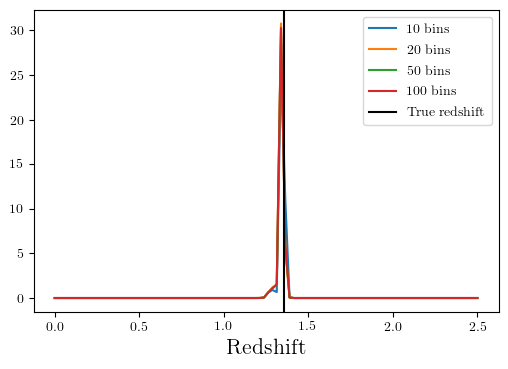

In [18]:
fig, ax = plt.subplots(dpi=100)
for i in [10, 20, 50, 100]:
    pdfs_u_marginalized[i][0].plot_native(axes=ax, label=f"{i} bins")
ax.axvline(samples_degraded.iloc[3]["redshift"], label="True redshift", c="k")
ax.legend()
ax.set(xlabel="Redshift")
plt.show()

Notice that the resolution with only 10 bins is sufficient for this marginalization.

In this example, only one of the bands featured a non-detection, but you can easily marginalize over more bands by including corresponding rules in the `marg_rules` dict. For example, let's artificially force a non-detection in the y band as well:

In [19]:
sample_double_degraded = samples_degraded.iloc[3:4].copy()
sample_double_degraded.iloc[0, 11:] *= np.nan
sample_double_degraded

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
3,1.35813,NaN,NaN,27.100063,0.167253,25.723847,0.046689,23.919356,0.014292,23.233337,0.013787,NaN,NaN


In [20]:
# set up the marginalization rules for u and y marginalization
marg_rules = {
    "flag": errorModel.settings["ndFlag"],
    "u": lambda row: np.linspace(27, 31, 10),
    "y": lambda row: np.linspace(21, 25, 10),
}

# calculate the posterior by marginalizing over u and y, and sampling
# from the error distributions of the other galaxies
pdf_double_marginalized = creator_degraded.get_posterior(
    sample_double_degraded, 
    grid=grid, 
    err_samples=10000, 
    seed=0, 
    marg_rules=marg_rules,
)

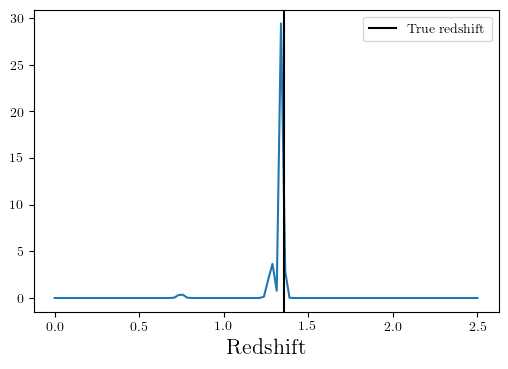

In [21]:
fig, ax = plt.subplots(dpi=100)
pdf_double_marginalized[0].plot_native(axes=ax)
ax.axvline(sample_double_degraded.iloc[0]["redshift"], label="True redshift", c="k")
ax.legend()
ax.set(xlabel="Redshift")
plt.show()

Note that marginalizing over multiple bands quickly gets expensive